# Fine-tuning SAM on Satellite Images for Street Segmentation


---
### What to fine-tune:
- Only Mask Decoder
- Prompt Encoder & Mask Decoder

---
### Prompt Encoder: 
SAM has an prompt encoder part that takes either a list of point queries, a list of bounding boxes or masks as input. How can we use the prompt encoder in our pipeline?

#### Training

Use as input either: 
- No input
- List of point queries: 
    - Uniformly overlay the whole image with a grid of points
    - Sample coordinates of the street pixels as point queries
- Bounding box of whole image, part where streets are located, could split up streets into multiple bounding boxes
- Masks of the street pixels, could leak ground truth information? 

#### Evaluation/Testing 

- List of point queries: 
    - Uniformly overlay the whole image with a grid of points
- No input
- Bounding box of whole image

---
### Loss function: 
- F1-Loss: https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing

--- 
## Things we could try later:  

Since the model is promptable, try to chain the model using the mask input. Maybe use a similar approach as in diffusion models


In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import sam_dataset

device = get_torch_device(allow_mps=False)
print(device)


###########
sat_images = load_training_images()
sat_masks = load_groundtuth_images()

# create a dataset
prompt_choices = ["None", "point_queries_grid", "point_queries_sample_mask"]
grid_points = 7

# list of numpy transforms that can be applied to the data before they get processed by SAM.
transforms = [] # [np.flipud, np.fliplr] # e.g. flip vertical and horizontal still needs to be implemented
data_set = sam_dataset(sat_images, sat_masks, prompt_options=[prompt_choices[1],grid_points], transforms=transforms)

print(len(data_set[0]))

cpu
3


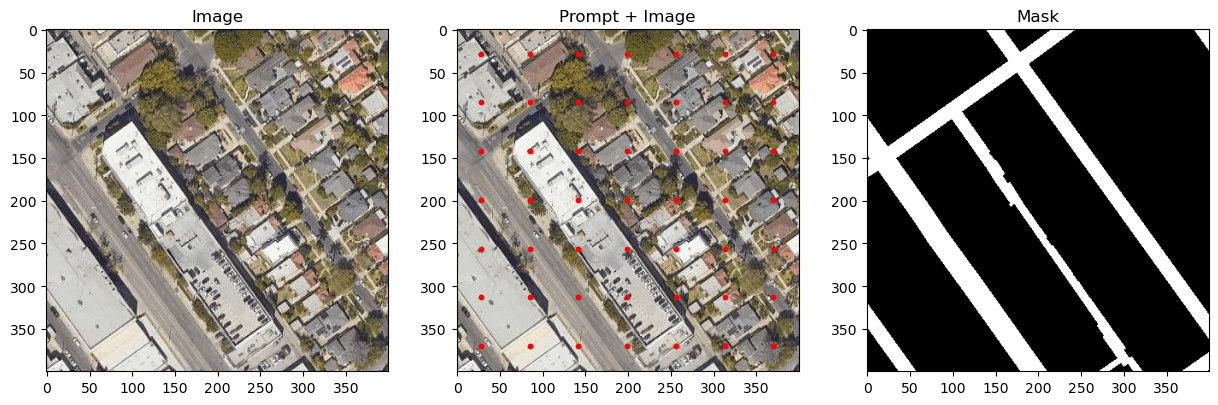

Prompt:  [array([[ 28,  28],
       [ 28,  85],
       [ 28, 142],
       [ 28, 199],
       [ 28, 256],
       [ 28, 313],
       [ 28, 370],
       [ 85,  28],
       [ 85,  85],
       [ 85, 142],
       [ 85, 199],
       [ 85, 256],
       [ 85, 313],
       [ 85, 370],
       [142,  28],
       [142,  85],
       [142, 142],
       [142, 199],
       [142, 256],
       [142, 313],
       [142, 370],
       [199,  28],
       [199,  85],
       [199, 142],
       [199, 199],
       [199, 256],
       [199, 313],
       [199, 370],
       [256,  28],
       [256,  85],
       [256, 142],
       [256, 199],
       [256, 256],
       [256, 313],
       [256, 370],
       [313,  28],
       [313,  85],
       [313, 142],
       [313, 199],
       [313, 256],
       [313, 313],
       [313, 370],
       [370,  28],
       [370,  85],
       [370, 142],
       [370, 199],
       [370, 256],
       [370, 313],
       [370, 370]]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [2]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 9

image = data_set[idx][0]
prompt = data_set[idx][1]
mask = data_set[idx][2]

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Prompt + Image")
plt.imshow(image)
# add all the points to the image
for point in prompt[0]:
    plt.scatter(point[0], point[1], c="r", s=10)

plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()

print("Prompt: ", prompt)


## Dataloader

In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(data_set, batch_size=1, shuffle=True, drop_last=False,num_workers=4)

In [4]:
for image,prompt,label in train_dataloader:
    print(image.shape, prompt, label)
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 145, in collate
    return elem_type([collate(samples, collate_fn_map=collate_fn_map) for samples in transposed])
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 145, in <listcomp>
    return elem_type([collate(samples, collate_fn_map=collate_fn_map) for samples in transposed])
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 148, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 148, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]
  File "/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


## Loading the model

In [3]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.custom_decoder import *


model_path = "custom_segment_anything/model_checkpoints/sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=model_path)

decoder_model = Conv_Decoder()

model = EncoderSAM_CustomDecoder(sam.preprocess, sam.image_encoder,decoder=decoder_model.decoder,encoder_finetune_num_last_layers=6)
model = model.to(device)

print(model)


/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last layer number: 456
EncoderSAM_CustomDecoder(
  (sam_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [6]:

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))




Model loaded
Trainable parameters 1093345
Total parameters 637200865
Percentage of trainable parameters: 
0.0017158561139115841
